# Capacity comparison of two windfarm datasets for EU countries

In this Jupyter Notebook we compare the recently published publicly available wind farm data set "Harmonised global datasets of wind and solar farm locations and power" with the common used wind farm data set "The Wind Power". Our focus in the analysis is on the investigation of the capacity distribution in the two data sets.

## Data sources

Dunnett, S., Sorichetta, A., Taylor, G. et al. Harmonised global datasets of wind and solar farm locations and power. Sci Data 7, 130 (2020). https://doi.org/10.1038/s41597-020-0469-8

The Wind Power. (2020). Available: https://www.thewindpower.net

NUTS regions. (2020). Available: https://ec.europa.eu/eurostat/de/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts

## Import python libraries¶

In [1]:
import numpy as np
import pandas as pd

#GEO
import geopandas as gpd
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

#KMeans Clustering 
#from sklearn.cluster import KMeans
#import geopy

#Helpers
import os
import pycountry

#Ploting
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

## Set data directories
Create input, processed and output folders if they don't exist.
If the paths are relative, the correspoding folders will be created inside the current working directory.


In [2]:
input_directory_path = os.path.join('input')
thewindpower_input_directory_path = os.path.join('input','thewindpower')
Harmonised_global_datasets_of_wind_and_solar_input_directory_path = os.path.join('input', 'Harmonised_global_datasets_of_wind_and_solar')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(thewindpower_input_directory_path, exist_ok=True)
os.makedirs(Harmonised_global_datasets_of_wind_and_solar_input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

In [3]:
thewindpower_filename = thewindpower_input_directory_path + '/Windfarms_Europe_20180326.xls'

H_Wind_filename = Harmonised_global_datasets_of_wind_and_solar_input_directory_path + '/global_wind_2020.csv'

Check the path and filename:

In [4]:
thewindpower_filename

'input/thewindpower/Windfarms_Europe_20180326.xls'

In [5]:
H_Wind_filename

'input/Harmonised_global_datasets_of_wind_and_solar/global_wind_2020.csv'

## Define import functions

In [6]:
def load_H_Wind_data(fn):
    """
    Load and standardize the raw wind data file from Harmonised_global_datasets_of_wind_and_solar.

    Parameters
    ----------
    fn : str
        filename

    """
    path = fn
    df = pd.read_csv(path, sep=",",\
                     index_col='wind_id')
    
    # rename column
    df.rename(columns={"GID_0": "country", "power":"capacity"}, inplace=True)

    return df.sort_index()


def load_thewindpower_data(fn):
    """
    Load and standardize the raw data file from thewindpower.


    Parameters
    ----------
    fn : str
        filename

    """
    
    path = fn
    df = pd.read_excel(fn, sheet_name='Windfarms', skiprows=[1])\
            .set_index('ID')\
            .replace('#ND',np.nan)
    
    # replace spaces in column names
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('\n', '_')
    
    # convert power to MW
    df.Total_power = df.Total_power/1000
    
    # rename column names 
    df.rename(columns={"ISO_code": "country", "Latitude": "Lat", "Longitude":"Lon", "Total_power":"capacity", "Number_of_turbines":"turbines"}, inplace=True)
    
    return df.sort_index()

## Set filter parameter

In [7]:
# countries to analyze
countries = ['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK']

#'AL', 
#missing in the data 'BA', 'MK'

#Dic to convert between alpha 3 and alpha 2
countries_dic = {}
for country in pycountry.countries:
    countries_dic[country.alpha_3] = country.alpha_2

## Load and filter data

### thewindpower
Dataset date 26.03.2018\
Capacities until 26.03.2018

In [8]:
# load and standardize the thewindpower
thewindpower = load_thewindpower_data(thewindpower_filename)

# filter to @countries
thewindpower = thewindpower.query('country in @countries')

# Filter data "Status and Offshore"
thewindpower = thewindpower.query('Status == "Production"')
thewindpower = thewindpower.query('Offshore_Shore_distance == "No"')

# Drop 
thewindpower.drop(columns=['Continent', 'Country', 'State_code', 'Area', 'City', 'Name',\
                           '2nd_name', 'Altitude/Depth', 'Location_accuracy',\
                           'Offshore_Shore_distance', 'Manufacturer', 'Turbine',\
                           'Hub_height','Developer','Operator', 'Owner',], inplace=True)

check the countries available in the data set 

In [9]:
thewindpower.country.unique()

array(['FR', 'DE', 'BE', 'RO', 'SE', 'AT', 'GB', 'SK', 'CH', 'IE', 'PT',
       'NL', 'IT', 'DK', 'LU', 'ES', 'GR', 'NO', 'LV', 'FI', 'EE', 'LT',
       'PL', 'HU', 'BG', 'HR', 'CZ', 'SI', 'ME', 'RS'], dtype=object)

### Harmonised_global_datasets_of_wind_and_solar
Dataset date 05.06.2020\
Capacities until end of 2018

In [10]:
# load and standardize the Harmonised_global_datasets_of_wind_and_solar

H_Wind = load_H_Wind_data(H_Wind_filename)

# convert to alpha 2
H_Wind = H_Wind.replace({"country": countries_dic})

# filter to @countries
H_Wind = H_Wind.query('country in @countries')

check the countries available in the data set 

In [11]:
H_Wind.country.unique()

array(['GB', 'FR', 'ES', 'IE', 'PT', 'DK', 'DE', 'NL', 'EE', 'SE', 'AT',
       'CH', 'PL', 'BE', 'HU', 'CZ', 'IT', 'SK', 'LV', 'LU', 'BG', 'GR',
       'SI', 'LT', 'RO', 'NO', 'FI', 'HR', 'ME', 'RS'], dtype=object)

## Check up for both datasets

check if both dataset countaining the same countries

In [12]:
set(H_Wind.country.unique())-set(thewindpower.country.unique())

set()

In [13]:
set(thewindpower.country.unique())-set(H_Wind.country.unique())

set()

Installed capacity in datasets

In [14]:
H_Wind.capacity.sum()

114558.97499519734

In [15]:
thewindpower.capacity.sum()

144352.27899999998

In [16]:
thewindpower.head()

,country,Lat,Lon,turbines,capacity,Commissioning_date,Status,Update
ID,,,,,,,,
1,FR,46.957937,-2.041998,5.0,12.00,2003/07,Production,2018-02-05
2,FR,46.946571,-2.052126,3.0,7.50,2003/06,Production,2018-02-05
3,DE,54.320000,9.190000,3.0,2.25,NaN,Production,2012-05-05
4,DE,54.220000,8.930000,1.0,1.50,NaN,Production,2015-08-31
5,FR,48.836136,4.660606,14.0,11.90,2005/07,Production,2017-09-06


In [17]:
H_Wind.head()

,X,Y,country,turbines,landscape.area,water,urban,capacity
wind_id,,,,,,,,
1866,-49332.358722,6.303608e+06,GB,1,2.010619,0,0,NaN
1867,-77777.465751,6.211812e+06,GB,1,2.010619,0,1,NaN
1868,-18921.157416,6.229784e+06,GB,1,2.010619,0,1,NaN
1869,-98092.631184,6.525381e+06,GB,1,2.010619,0,0,NaN
1870,-5938.467059,6.289412e+06,GB,1,2.010619,0,1,NaN


## Per country analysis

Group the data per country and check some statistics.

In [18]:
H_Wind[['turbines','capacity','country','X','Y']].groupby(['country'])\
                                                .agg({\
                                                    'turbines': ['sum','mean', 'count', 'size'],
                                                    'capacity' : ['sum','mean', 'count', 'size'],
                                                    'X' : ['count', 'size'],
                                                    'Y' : ['count', 'size']})

turbines                             capacity                         \
             sum       mean count  size           sum       mean count  size   
country                                                                        
AT          1398   8.737500   160   160   1854.647555  28.100721    66   160   
BE           915   4.103139   223   223    634.193318  13.786811    46   223   
BG           470   4.895833    96    96    480.013254  17.778269    27    96   
CH            92   2.190476    42    42     41.010380  10.252595     4    42   
CZ           217   3.191176    68    68    143.128364  11.927364    12    68   
DE         28708   6.172436  4651  4651  34821.204505  20.776375  1676  4651   
DK          5926   2.518487  2353  2353   3880.934014  13.290870   292  2353   
EE           137   4.724138    29    29    134.932078  22.488680     6    29   
ES         19562  17.280919  1132  1132  24205.693426  28.954179   836  1132   
FI           660   3.041475   217   217    531.116094  16.094427    33   217   
FR         11355   8.337004  1362  1362  10950.039603  14.541885   753  1362   
GB         14727  10.982103  1341  1341   8670.325522  26.353573   329  1341   
GR          1915   9.527363   201   201   2518.852655  18.520975   136   201   
HR           272   5.913043    46    46    409.473103  17.061379    24    46   
HU           190   3.958333    48    48    240.191627  21.835602    11    48   
IE          1728   8.267943   209   209   2386.308861  23.626820   101   209   
IT          6607   8.774236   753   753   8464.655361  25.043359   338   753   
LT           316   3.009524   105   105    289.531522  20.680823    14   105   
LU            73   2.027778    36    36     36.751601  12.250534     3    36   
LV            84   3.500000    24    24     82.712202  13.785367     6    24   
ME            50  10.000000     5     5     89.423666  29.807889     3     5   
NL          2886   5.714851   505   505   2120.664151  20.588972   103   505   
NO          1093   9.262712   118   118   1773.492307  32.245315    55   118   
PL          3310   3.201161  1034  1034   2951.516730  16.306722   181  1034   
PT          2683   8.008955   335   335   3948.948676  20.147697   196   335   
RO           637   9.367647    68    68    625.269748  34.737208    18    68   
RS            12   2.000000     6     6      0.000000        NaN     0     6   
SE          2367   3.597264   658   658   2273.944670  19.773432   115   658   
SI            16   1.142857    14    14      0.000000        NaN     0    14   
SK            10   1.428571     7     7      0.000000        NaN     0     7   

            X           Y        
        count  size count  size  
country                          
AT        160   160   160   160  
BE        223   223   223   223  
BG         96    96    96    96  
CH         42    42    42    42  
CZ         68    68    68    68  
DE       4651  4651  4651  4651  
DK       2353  2353  2353  2353  
EE         29    29    29    29  
ES       1132  1132  1132  1132  
FI        217   217   217   217  
FR       1362  1362  1362  1362  
GB       1341  1341  1341  1341  
GR        201   201   201   201  
HR         46    46    46    46  
HU         48    48    48    48  
IE        209   209   209   209  
IT        753   753   753   753  
LT        105   105   105   105  
LU         36    36    36    36  
LV         24    24    24    24  
ME          5     5     5     5  
NL        505   505   505   505  
NO        118   118   118   118  
PL       1034  1034  1034  1034  
PT        335   335   335   335  
RO         68    68    68    68  
RS          6     6     6     6  
SE        658   658   658   658  
SI         14    14    14    14  
SK          7     7     7     7

In [19]:
thewindpower[['turbines', 'capacity', 'country', 'Lat', 'Lon']].groupby(['country'])\
                                                         .agg({\
                                                            'turbines': ['sum','mean', 'count', 'size'],
                                                            'capacity' : ['sum','mean', 'count', 'size'],
                                                            'Lon' : ['count', 'size'],
                                                            'Lat' : ['count', 'size']})

turbines                          capacity                         \
             sum       mean count  size        sum       mean count  size   
country                                                                     
AT        1206.0   4.483271   269   271   2683.677   9.902867   271   271   
BE         760.0   3.234043   235   235   1695.450   7.214681   235   235   
BG         334.0   4.704225    71    77    644.445   8.950625    72    77   
CH          37.0   1.947368    19    19     75.050   3.950000    19    19   
CZ         196.0   2.305882    85    85    306.910   3.610706    85    85   
DE       27109.0   3.535342  7668  7987  42642.592   5.347704  7974  7987   
DK        4144.0   1.868350  2218  2219   4154.862   1.872403  2219  2219   
EE         136.0   4.533333    30    30    309.910  10.330333    30    30   
ES       20125.0  17.715669  1136  1142  23301.390  20.404019  1142  1142   
FI         590.0   3.734177   158   158   1655.630  10.478671   158   158   
FR        6711.0   5.550868  1209  1209  13010.195  10.787890  1206  1209   
GB        6100.0   6.939704   879   881  11231.790  12.748910   881   881   
GR        1328.0  10.624000   125   192   2148.550  11.190365   192   192   
HR         226.0  10.761905    21    22    466.000  21.181818    22    22   
HU         199.0   4.234043    47    49    384.975   7.856633    49    49   
IE        1664.0   7.775701   214   230   3039.495  13.215196   230   230   
IT        7236.0  11.842881   611   632  10469.340  16.565411   632   632   
LT         156.0   3.120000    50    68    379.905   5.670224    67    68   
LU          66.0   2.750000    24    24    127.400   5.308333    24    24   
LV          50.0   5.555556     9    11     53.100   4.827273    11    11   
ME          26.0  26.000000     1     1     72.800  72.800000     1     1   
NL        2282.0   3.532508   646   646   3474.785   5.378924   646   646   
NO         468.0  11.700000    40    40   1151.400  28.785000    40    40   
PL        2288.0   8.766284   261   301   5687.033  18.893797   301   301   
PT        2772.0   6.476636   428   429   5386.600  12.556177   429   429   
RO        1091.0  17.317460    63   105   3579.225  34.087857   105   105   
RS          10.0   2.500000     4     4     25.000   6.250000     4     4   
SE        3174.0   3.037321  1045  1052   6186.130   5.880352  1052  1052   
SI           3.0   1.500000     2     2      5.500   2.750000     2     2   
SK           5.0   2.500000     2     2      3.140   1.570000     2     2   

          Lon         Lat        
        count  size count  size  
country                          
AT        267   271   267   271  
BE        234   235   234   235  
BG         74    77    74    77  
CH         19    19    19    19  
CZ         84    85    84    85  
DE       7445  7987  7445  7987  
DK       1918  2219  1918  2219  
EE         30    30    30    30  
ES       1085  1142  1085  1142  
FI        155   158   155   158  
FR       1205  1209  1205  1209  
GB        754   881   754   881  
GR        170   192   170   192  
HR         14    22    14    22  
HU         49    49    49    49  
IE        199   230   199   230  
IT        626   632   626   632  
LT         31    68    31    68  
LU         24    24    24    24  
LV         11    11    11    11  
ME          1     1     1     1  
NL        627   646   627   646  
NO         36    40    36    40  
PL        278   301   278   301  
PT        399   429   399   429  
RO         94   105    94   105  
RS          3     4     3     4  
SE        965  1052   965  1052  
SI          2     2     2     2  
SK          2     2     2     2

### Plot capacity per country

In [20]:
# new dataframe for capacity per country
capacity_per_country = pd.DataFrame()

In [21]:
# capacity per country from H_Wind
capacity_per_country['H_Wind'] = H_Wind.groupby(['country']).sum().capacity

In [22]:
# capacity per country from thewindpower
capacity_per_country['thewindpower'] = thewindpower.groupby(['country']).sum().capacity

In [23]:
# Capacity difference between datasets  
capacity_per_country['dif'] = capacity_per_country['H_Wind'] - capacity_per_country['thewindpower']

Plot data and save it in the output directory

<Figure size 1080x432 with 0 Axes>

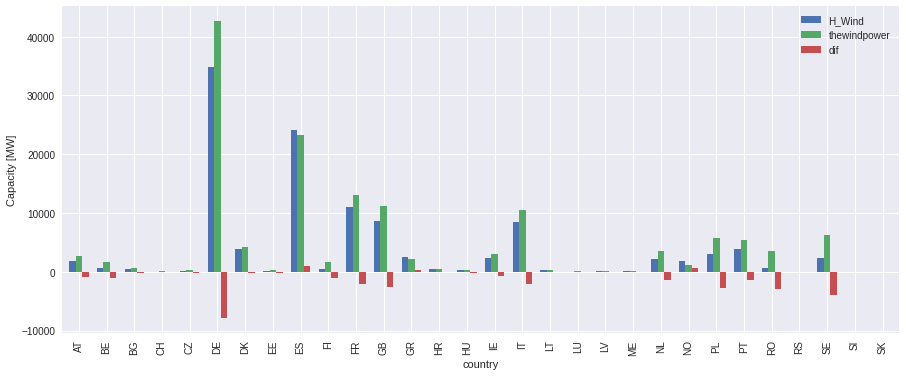

In [24]:
plt.figure()

ax = capacity_per_country.plot.bar(width=0.7)
ax.set_ylabel("Capacity [MW]")

plt.savefig(os.path.join(output_directory_path, 'capacity_per_country.png'))

In [25]:
#check numbers if you want
#power_per_country

### Plot data per dataset

In [26]:
#plot = sns.barplot(x=capacity_per_country.index, y='H_Wind' ,data=capacity_per_country)

In [27]:
#plot = sns.barplot(x=capacity_per_country.index, y='thewindpower', data=capacity_per_country)

## Check distribution of capacity per NUTS region

### GEO Data setup

Importing coordinate reference systems (EPSG 3426 & eck4)

In [28]:
crs_4326 = CRS.from_epsg(4326)

#check info for epsg 3426
#crs_4326

In [29]:
crs_eck4 = CRS.from_proj4('+proj=eck4')

#check info for eck4
#crs_eck4

In [30]:
#build transfromer function to convert coordinates
transformer = Transformer.from_crs(crs_eck4, crs_4326, always_xy=True)

Convert coordinates in H_Wind from crs_eck4 to crs_4326

In [31]:
#convert x and y coordinates from eck4 to Lat and Lon Coordinates too epsg 3426
H_Wind_lat_lon = transformer.transform(H_Wind['X'].to_list(), H_Wind['Y'].to_list()) 

H_Wind['Lon'] = list(H_Wind_lat_lon[0])
H_Wind['Lat'] = list(H_Wind_lat_lon[1])

Check and remove entries with coordinates nan values

In [32]:
#check H_Wind dataset
print(H_Wind.Lat.isna().sum())
print(H_Wind.Lon.isna().sum())

0
0


In [33]:
#check thewindpower dataset
print(thewindpower.Lat.isna().sum())
print(thewindpower.Lon.isna().sum())

1322
1322


In [34]:
#check missing capacity
print(thewindpower[thewindpower.Lat.isna()].capacity.sum())
print(thewindpower[thewindpower.Lon.isna()].capacity.sum())

10970.26
10970.26


#### !!! Around 10 GW installed capacity have no coordinate information. But possibly name of the city. This should be checked further. !!!

In [35]:
#drop nan values
thewindpower.dropna(axis=0, how='any', subset=['Lat', 'Lon'], inplace=True)

Convert coordinates to geo data and set a crs for both data sets

In [36]:
geom = thewindpower.apply(lambda x : Point([x['Lon'],x['Lat']]),axis=1)
thewindpower = gpd.GeoDataFrame(thewindpower, geometry=geom) #geom is a Series

thewindpower.crs = 'epsg:4326'
                
print(thewindpower.head())
print(thewindpower.crs)

   country        Lat       Lon  turbines  capacity Commissioning_date  \
ID                                                                       
1       FR  46.957937 -2.041998       5.0     12.00            2003/07   
2       FR  46.946571 -2.052126       3.0      7.50            2003/06   
3       DE  54.320000  9.190000       3.0      2.25                NaN   
4       DE  54.220000  8.930000       1.0      1.50                NaN   
5       FR  48.836136  4.660606      14.0     11.90            2005/07   

        Status     Update                   geometry  
ID                                                    
1   Production 2018-02-05  POINT (-2.04200 46.95794)  
2   Production 2018-02-05  POINT (-2.05213 46.94657)  
3   Production 2012-05-05   POINT (9.19000 54.32000)  
4   Production 2015-08-31   POINT (8.93000 54.22000)  
5   Production 2017-09-06   POINT (4.66061 48.83614)  
epsg:4326


In [37]:
geom = H_Wind.apply(lambda x : Point([x['Lon'],x['Lat']]),axis=1)
H_Wind = gpd.GeoDataFrame(H_Wind, geometry=geom) #geom is a Series

H_Wind.crs = 'epsg:4326'
                
print(H_Wind.head())
print(H_Wind.crs)

                    X             Y country  turbines  landscape.area  water  \
wind_id                                                                        
1866    -49332.358722  6.303608e+06      GB         1        2.010619      0   
1867    -77777.465751  6.211812e+06      GB         1        2.010619      0   
1868    -18921.157416  6.229784e+06      GB         1        2.010619      0   
1869    -98092.631184  6.525381e+06      GB         1        2.010619      0   
1870     -5938.467059  6.289412e+06      GB         1        2.010619      0   

         urban  capacity       Lon        Lat                   geometry  
wind_id                                                                   
1866         0       NaN -0.629603  52.362522  POINT (-0.62960 52.36252)  
1867         1       NaN -0.985582  51.418656  POINT (-0.98558 51.41866)  
1868         1       NaN -0.240095  51.602423  POINT (-0.24010 51.60242)  
1869         0       NaN -1.275230  54.700611  POINT (-1.27523 5

### Import NUTS regions

Importing NUTS regions from geo jason file (see sources).

In [38]:
#using different NUTS file names; the resolution can be changed from NUTS 0 (Countries) upto NUTS 3 (Citys)

#in the following it is set to NUTS 2 (...4326_LEVL_2.geojson)

geojson_file = 'input/ref-nuts-2016-01m/NUTS_RG_01M_2016_4326_LEVL_2.geojson'
NUTS = gpd.read_file(geojson_file)[['geometry','NUTS_ID']]
print('The selected NUTS level has ' + str(len(NUTS)) +' regions')
print('The file has the following crs: ' + str(NUTS.crs))
print('First entries of the selected NUTS data')
print(NUTS.head())


The selected NUTS level has 332 regions
The file has the following crs: epsg:4326
First entries of the selected NUTS data
                                            geometry NUTS_ID
0  MULTIPOLYGON (((7.37568 47.41408, 7.38398 47.4...    CH02
1  MULTIPOLYGON (((7.37568 47.41408, 7.37813 47.4...    CH03
2  POLYGON ((20.23617 41.34849, 20.26187 41.35376...    AL02
3  MULTIPOLYGON (((20.59775 41.09203, 20.63287 41...    AL03
4  MULTIPOLYGON (((28.57888 43.73874, 28.57256 43...    BG33


## Define join intersection function

Function for the intersection of NUTS regions and wind turbine capacities in the data sets.  

In [39]:
def compair_to_NUTS(NUTS=NUTS, country='DE', H_Wind=H_Wind, thewindpower=thewindpower):
    
    #Filter data to country (using alpha 2 code).
    X_H_Wind=H_Wind.loc[H_Wind.country == country,['capacity','Lat','Lon','geometry']]
    
    X_thewindpower=thewindpower.loc[thewindpower.country == country,['capacity','Lat','Lon','geometry']]
    
 
    #Join the NUTS regions with the coordinates of the wind turbines
    X_H_Wind_and_NUTS = gpd.sjoin(X_H_Wind, NUTS, op='within')
    
    X_thewindpower_and_NUTS = gpd.sjoin(X_thewindpower, NUTS, op='within')
    
    #Group the data per NUTS regions
    H_Wind_X_agg = X_H_Wind_and_NUTS[['capacity','NUTS_ID']].groupby(['NUTS_ID'])\
                                                        .agg({'capacity' : ['sum','mean', 'count', 'size']})
    
    thewindpower_X_agg =X_thewindpower_and_NUTS[['capacity','NUTS_ID']].groupby(['NUTS_ID'])\
                                                        .agg({'capacity' : ['sum','mean', 'count', 'size']})
    
    #Join data into one dataframe
    Data_join = NUTS.join(H_Wind_X_agg['capacity']['sum'], on='NUTS_ID', how='inner').rename(columns={"sum": "H_Wind_X_Cap"})
    
    Data_join = Data_join.join(thewindpower_X_agg['capacity']['sum'], on='NUTS_ID', how='inner').rename(columns={"sum": "thewindpower_X_Cap"})
    
    #area of NUTS regions (CRS need to be changed because crs is not in meter)
    Data_join["area"] = Data_join['geometry'].to_crs(epsg='3395')\
                                             .map(lambda p: p.area / 10**6)
    
    
    Data_join['thewindpower_X_Cap_Density'] = Data_join.thewindpower_X_Cap / Data_join.area
    Data_join['H_Wind_X_Cap_Density'] = Data_join.H_Wind_X_Cap / Data_join.area

    Data_join['Density_dif'] = Data_join['H_Wind_X_Cap_Density'] - Data_join['thewindpower_X_Cap_Density']
    
    #Normalizing the capacity value in the dataframe for comparision
    column_maxes = Data_join[['H_Wind_X_Cap','thewindpower_X_Cap']].max()

    Data_join_max = column_maxes.max()

    Data_join[['H_Wind_X_Cap_norm','thewindpower_X_Cap_norm']] = Data_join[['H_Wind_X_Cap','thewindpower_X_Cap']] / Data_join_max
    
    return(Data_join)

Join NUTS regions and wind turbine data for a given country

In [40]:
Data_join = compair_to_NUTS(NUTS=NUTS, country='DE', H_Wind=H_Wind, thewindpower=thewindpower)

Check the resulting geo dataframe

In [41]:
Data_join.head()

,geometry,NUTS_ID,H_Wind_X_Cap,thewindpower_X_Cap,area,thewindpower_X_Cap_Density,H_Wind_X_Cap_Density,Density_dif,H_Wind_X_Cap_norm,thewindpower_X_Cap_norm
5,"MULTIPOLYGON (((8.22201 48.60323, 8.21404 48.6...",DE13,32.548961,183.63,20944.008868,161.976745,28.710857,-133.265887,0.005827,0.032874
15,"POLYGON ((10.23078 48.51051, 10.23266 48.50851...",DE14,45.508673,72.04,20434.499583,65.263265,41.227715,-24.035550,0.008147,0.012897
21,"MULTIPOLYGON (((11.59931 48.95150, 11.62117 48...",DE21,42.175700,134.67,39167.913633,63.614537,19.922682,-43.691855,0.007550,0.024109
45,"MULTIPOLYGON (((10.08372 49.54356, 10.08747 49...",DE11,539.828443,460.49,24448.172728,354.879346,416.021987,61.142641,0.096642,0.082439
46,"POLYGON ((13.41665 48.98004, 13.42409 48.97691...",DE22,0.000000,28.43,23619.017087,22.537553,0.000000,-22.537553,0.000000,0.005090


## Define plotting functions

### Def. capacity distribution function

In [42]:
def plot_cap_distribution(Data_join,country,show_plot=False):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.suptitle("Capacities distribution in " + country, fontsize=16)

    divider = make_axes_locatable(ax1)

    cax = divider.append_axes("right", size="5%", pad=0.1)

    Data_join.plot(column='H_Wind_X_Cap',
               ax=ax1,
               cax=cax,
               legend=True,
               legend_kwds={'label': "Capacity per NUTS region [MW]", 'orientation': "vertical"},
               cmap='Blues',
               vmin=0,
               vmax=Data_join[['H_Wind_X_Cap','thewindpower_X_Cap']].max().max())

    ax1.title.set_text('Capacity per NUTS region for H_Wind')


    divider = make_axes_locatable(ax2)

    cax = divider.append_axes("right", size="5%", pad=0.1)

    Data_join.plot(column='thewindpower_X_Cap',
               ax=ax2,
               cax=cax,
               legend=True,
               legend_kwds={'label': "Capacity per NUTS region [MW]", 'orientation': "vertical"},
               cmap='Blues',
               vmin=0,
               vmax=Data_join[['H_Wind_X_Cap','thewindpower_X_Cap']].max().max())

    ax2.title.set_text('Capacity per NUTS region for thewindpower')
    
    fig.savefig(os.path.join(output_directory_path, country + '_capacity_per_NUTS.png'))
    
    if not show_plot: 
        plt.close()
    

### Def. density difference plot function

In [43]:
def plot_density_difference(Data_join,country,show_plot=False):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax = plt.subplots(1, 1)

    fig.suptitle("Density difference plot for " + country, fontsize=16)

    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size="5%", pad=0.1)

    Data_join.plot(column='Density_dif',
               ax=ax,
               cax=cax,
               legend=True,
               legend_kwds={'label': "Capacity density diff per NUTS region [MW/km²]", 'orientation': "vertical"},
               cmap='Blues')

    ax.title.set_text('Density difference plot for capacities in the NUTS regions')
    
    fig.savefig(os.path.join(output_directory_path, country + '_capacity_density_diff_per_NUTS.png'))
    
    if not show_plot: 
        plt.close()
    

### Def. jointplot function

In [44]:
def plot_jointplot(Data_join,country,show_plot=False):
    
 
    sns.jointplot("H_Wind_X_Cap", "thewindpower_X_Cap", data=Data_join, kind="reg", height=12)
    
    plt.title('Difference plot for '+ country +' in NUTS X resolution')
    
    plt.savefig(os.path.join(output_directory_path, country + '_difference_plot_for_capacities_in_NUTS.png'))
    
    if not show_plot: 
        plt.close()
    
     

Generating plots for a given country

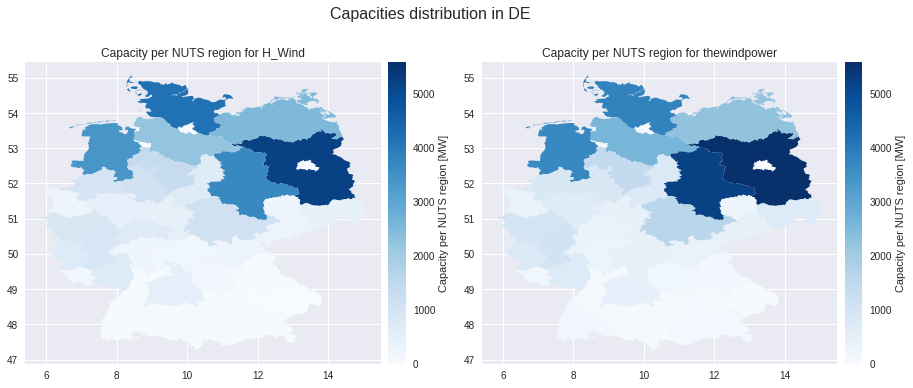

In [45]:
plot_cap_distribution(Data_join,country='DE',show_plot=True)

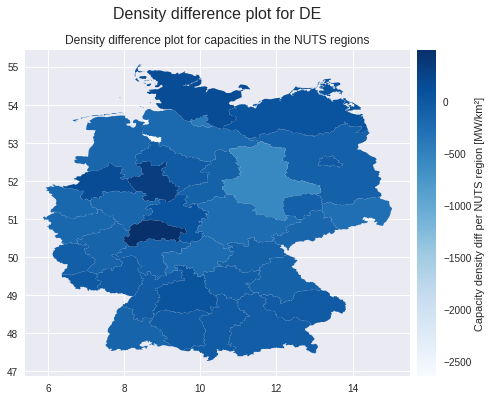

In [46]:
plot_density_difference(Data_join,country='DE',show_plot=True)

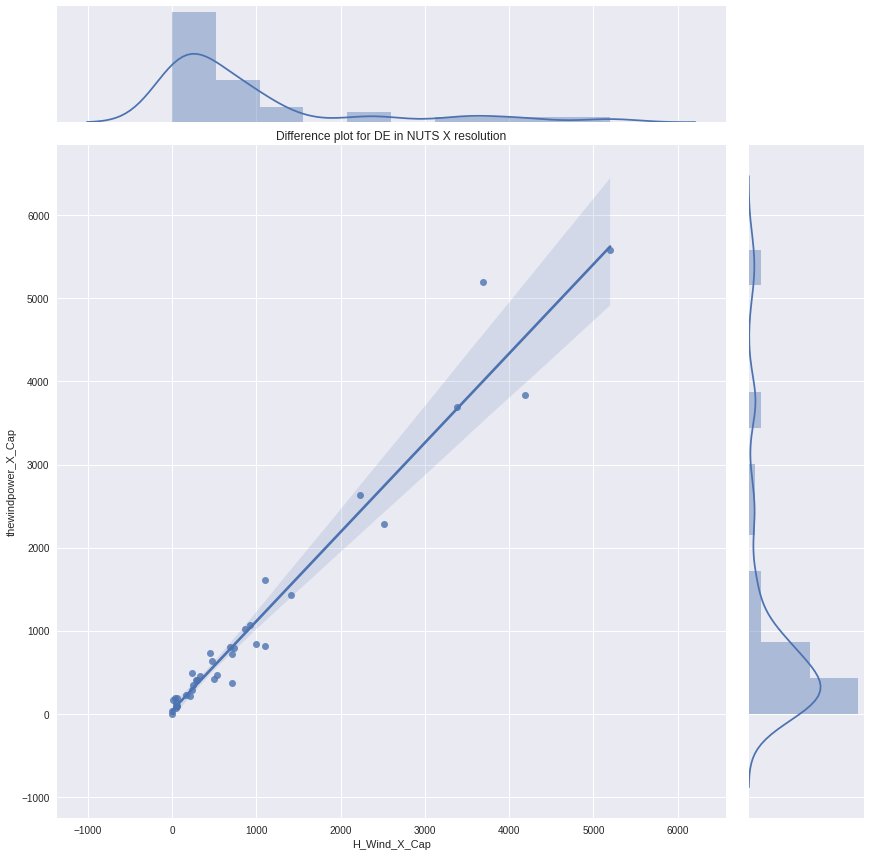

In [47]:
plot_jointplot(Data_join,country='DE',show_plot=True)

Run simulations for all countries in @countries and save the figures in the output folder

In [48]:
for i in countries:
    Data_join = compair_to_NUTS(NUTS=NUTS, country=i, H_Wind=H_Wind, thewindpower=thewindpower)
    plot_cap_distribution(Data_join,country=i,show_plot=False)
    plot_density_difference(Data_join,country=i,show_plot=False)
    if (len(Data_join.NUTS_ID.unique()) <= 2):
        continue
    plot_jointplot(Data_join,country=i,show_plot=False)

Difference plot for capacities in the NUTS regions 

In [49]:
## new dataframe for capacity per country
#Data_NUTS = pd.DataFrame()
#
#Data_NUTS = Data_join[['H_Wind_X_Cap','thewindpower_X_Cap', 'NUTS_ID']].copy()
#Data_NUTS.set_index('NUTS_ID', inplace=True)
#
# Capacity difference between NUTS regions  
#Data_NUTS['dif'] = Data_NUTS['H_Wind_X_Cap'] - Data_NUTS['thewindpower_X_Cap']
#Data_NUTS.plot.bar(title='Capacity difference between NUTS regions')